# MacCormack's Method

Given a set of equations in the form:

\begin{equation}
\frac{\partial {\bf E}}{\partial \xi} + 
\frac{\partial {\bf F}}{\partial \eta} +
{\bf H} = 0
\end{equation}

Where $\xi$ and $\eta$ are generalized, non-orthogonal, coordinates in the axial and radial directions.

The computational grid is a set of evenly spaced points running from the surface of the ogive-cylinder body to a point assumed to be beyond the shock wave formed over the body while moving at hypersonic speeds. This outer boundary is just a cone of some set cone angle. The solution assumes that the first point away from the body surface is supersonic. Therefore, we are not attempting to model the boundary layer near the body surface.

We will count points in the two spacial directions using indexes **i** for radial points, and **j** for axial points.

MacCormack's method solves this equation in two steps, called *Predictor-Corrector*:

## Predictor Step:

We pproximate derivatives in each direction using simple finite-differencing:

\begin{equation}
\frac{E^\overline{j+1}_i- E^j_i}{\Delta \xi} +
\frac{F^j_{i+1} - F^j_i}{\Delta \eta}
+ {\bf H}^j_i = 0
\end{equation}

or

\begin{equation}
E^\overline{j+1}_i =  E^j_i - \frac{\Delta \xi}{\Delta \eta}\left(
F^j_{i+1} - F^j_i
\right)
+ {\bf H}^j_i = 0
\end{equation}

## Corrector Step

\begin{equation}
E^{j+\frac{1}{2}}_i =
\frac{E^j_i + E^\overline{j + 1}_i}{2}
\end{equation}

\begin{equation}
E^{j+1}_i =  E^\overline{j+\frac{1}{2}}_i - \frac{\Delta \xi}{2\Delta \eta}\left(
F^\overline{j+1}_i - F^\overline{j+1}_{i-1}
\right)
+ {\bf H}^j_i = 0
\end{equation}

or

\begin{equation}
E^{j+1}_i =  \frac{E^j_i + E^\overline{j+1}_i}{2} - \frac{\Delta \xi}{2\Delta \eta}\left(
F^\overline{j+1}_i - F^\overline{j+1}_{i-1}
\right)
+ {\bf H}^\overline{j+1}_i = 0
\end{equation}

## Spatial Marching

The solution technique involves marching in the $\xi$ direction. Assuming we have a solution for all $\eta$ points at some point $\xi$, we loop over $\eta$ from the body to the outer boundary using the *predictor* equation to calculate new properties for the point at $\eta$ and $\xi + \Delta\xi$. This step involves forward differences in the $\eta$ direction, meaning we need points at $\eta$ and $\eta - \Delta \eta$. We cannot use the *corrector* step at the same time since that step uses backward differences that will require values ahead of the loop. We can solve this problem by storing *predictor* values in a small working array. We can apply the *corrector* equation as soon as we have two value sin this working array. The corrector step thus lags the predictor step by one $\eta$ value. We can safely overwrite the solution array at this point so that the loop will produce all values at the new value of $\xi$. 

This scheme significantly reduces the memory needed to generate a solution at the expense of managing the working array. We will need to shift values in the working array as we sweep over the primary loop.

Let's look at the code, using Python for this example

## Simple Wave Equation

In this section, we will use an example from [Numerical Computation of Compressible and Viscous Flow](maccormack2014) to explore the marching algorithm.

The equation we will model is a simple wave flow model:

\begin{equation}
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0
\end{equation}

Where **u** is the local velocity and **c** is the wave speed.

We will use initial conditions used in the reference:

\begin{equation}
    u=
    \begin{cases}
      1, & \text{if}\ x \leq \frac{1}{2} \\
      \frac{1}{2}, & \text{if}\ x \gt \frac{1}{2}
    \end{cases}
  \end{equation}

In [1]:
nx = 41
dx = 2/40
nt = 10
c = 1
dt = 0.9*dx/c

In [2]:
import numpy as np
u = np.zeros((nx))
ui = np.zeros((nx))
x = np.zeros((nx))
du = np.zeros((nx))
print(du.size)

41


In [3]:
import math

for i in range(0,nx):
    x[i] = i*dx
    if x[i] <= 0.5:
        ui[i] = 1.0
    else:
        ui[i] = 0.5
        
def ureset():
    for i in range(0,nx):
        u[i] = ui[i]

In [4]:
import matplotlib.pyplot as plt

def show_curve(x,y,title,xlabel,ylabel):
    plt.plot(x,y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

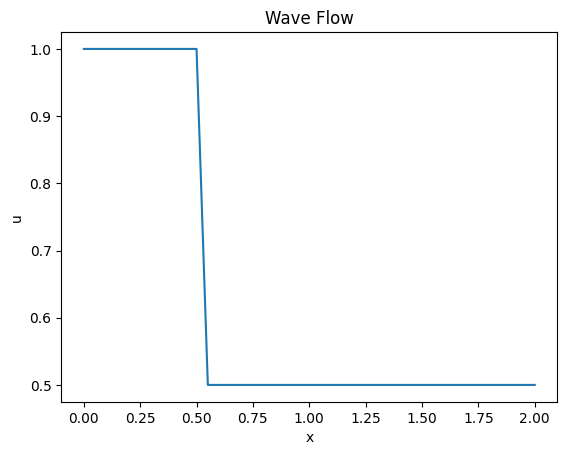

In [5]:
ureset()
show_curve(x,u,"Wave Flow","x","u")

### Finite Differences

We use a simple scheme, based on a first-order *Taylor's Series* to come up with equations for the derivatives:

\begin{equation}
\frac{\partial u}{\partial t} = \frac{u^{n+1}_i - u^n_i}{\Delta t}
\end{equation}

Where **j** indicated the time value, and **i** the **x** value.

\begin{equation}
t = t_0 + n{\Delta t} \\
x = x_0 + i{\Delta x}
\end{equation}

\begin{equation}
\frac{\partial u}{\partial x} = \frac{u^n_i - u^n_{i-1}}{\Delta x}
\end{equation}


Substituting these two finite difference equations into our example equation gives us a new equation we can use generate new values, marching in time:

\begin{equation}
\frac{u^{n+1}_i - u^n_i}{\Delta t} +
c \frac{u^n_i - u^n_{i-1}}{\Delta x} = 0
\end{equation}

Rearranging:

\begin{equation}
u^{n+1}_i =  u^n_i -
\frac{c\Delta t}{\Delta x}(u^n_i - u^n_{i-1}) = 0
\end{equation}

The exact solution is given by:

\begin{equation}
u(x,t) = g(x - c(t-t_0))
\end{equation}

We can demonstrate this scheme using Python:

In [6]:
# reset initial conditions
ureset()
    
# loop over time
for n in range(0,nt):
    t = n*dt
    # calculate backward differences
    for i in range(1,nx):
        du[i] = u[i] - u[i-1]
        
    # update u[i] for next time value
    for i in range(1,nx):
        u[i] = u[i] - c * dt/dx * du[i] 

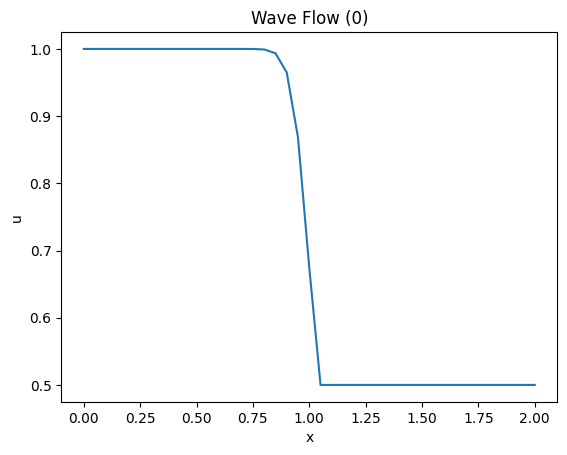

In [7]:
show_curve(x,u,"Wave Flow (%d)" % t,"x","u")

Just for fun, let's try this using forward differences:

In [8]:
# reset initial conditions
ureset()
    
# loop over time
for n in range(0,nt):
    t = n*dt
    
    # calculate forward differences
    for i in range(0,nx-1):
        du[i] = u[i+1] - u[i]
        
    # update u[i] for next time value
    for i in range(0,nx-1):
        u[i] = u[i] - c * dt/dx * du[i] 

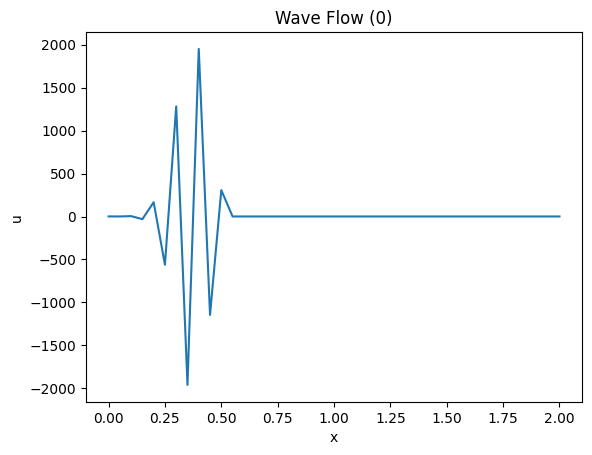

In [9]:
show_curve(x,u,"Wave Flow (%d)" % t,"x","u")

This certainly does not look good! Let's try another scheme

### Using MacCormack's Method

The previous example uses a first-order accurate approximation for the spatial derivative. *MacCormack's method will produce a more accurate second order approximation.

The predictor step is identical to the previous example. The corrector 
step needs to be added.

Predictor:

\begin{equation}
u^\overline{n+1}_i =  u^n_i -
\frac{c\Delta t}{\Delta x}(u^n_i - u^n_{i-1}) = 0
\end{equation}

Corrector:

\begin{equation}
u^{n+1}_i =  \frac{u^j_i + u^\overline{n+1}_i}{2} - \frac{c\Delta t}{2\Delta x}\left(
u^\overline{n+1}_{i+1} - u^\overline{n+1}_{i}
\right)
\end{equation}


In [10]:
# create storage for predictor values
up = np.zeros((nx))
du = np.zeros((nx))

In [11]:
ureset()

# loop over time
for n in range(0,nt):
    t - n * dt
    
    # predictor - backward differences
    for i in range(1,nx):
        du[i] = u[i] - u[i-1]
        up[i] = u[i] - c * dt/dx * du[i]
    up[0] = u[0] # update left bundary
    
    # Corrector - forward differences
    for i in range(0,nx-1):
        du[i] = up[i+1] - up[i]
        u[i] = 0.5*(u[i] + up[i] - c * dt/dx * du[i]) 

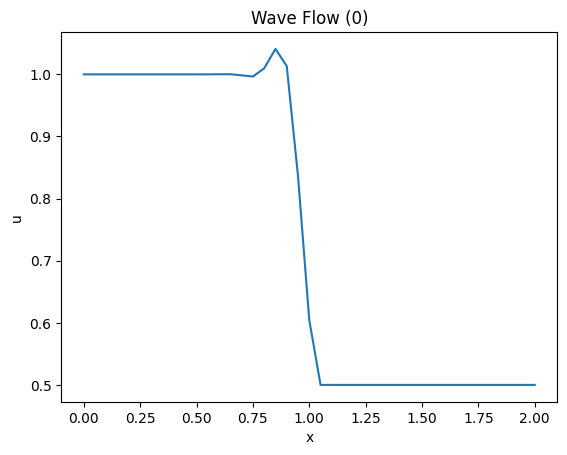

In [12]:
show_curve(x,u,"Wave Flow (%d)" % t,"x","u")
    

Let's try reversing the order of the differences:

In [13]:
ureset()

# loop over time
for n in range(0,nt):
    t - n * dt
    
    # predictor - forward differences
    for i in range(0,nx-1):
        du[i] = u[i+1] - u[i]
        up[i] = u[i] - c * dt/dx * du[i]
    up[nx-1] = u[nx-1] # update right bundary
    
    # Corrector - backward differences
    for i in range(1,nx):
        du[i] = up[i] - up[i-1]
        u[i] = 0.5*(u[i] + up[i] - c * dt/dx * du[i]) 

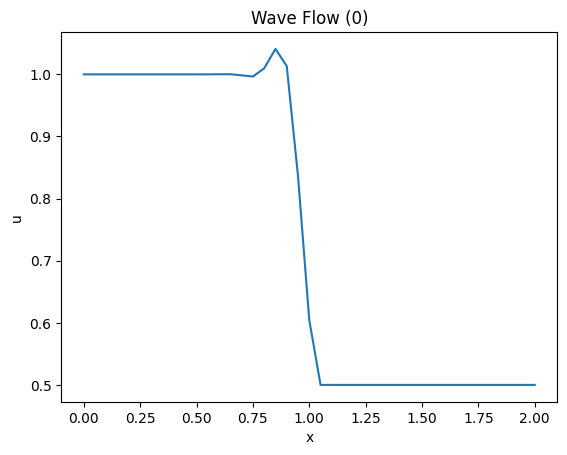

In [14]:
show_curve(x,u,"Wave Flow (%d)" % t,"x","u")    

In [15]:
ureset()

# loop over time
for n in range(0,nt):
    t - n * dt
    
    # predictor - backward differences
    for i in range(1,nx):
        du[i] = u[i] - u[i-1]
        up[i] = u[i] - c * dt/dx * du[i]
    up[0] = u[0] # update left boundary
    
    for i in range(0,nx-1):
        du[i] = up[i+1] - up[i]
        
        u[i] = 0.5*(u[i] + up[i] - c * dt/dx * du[i])
        

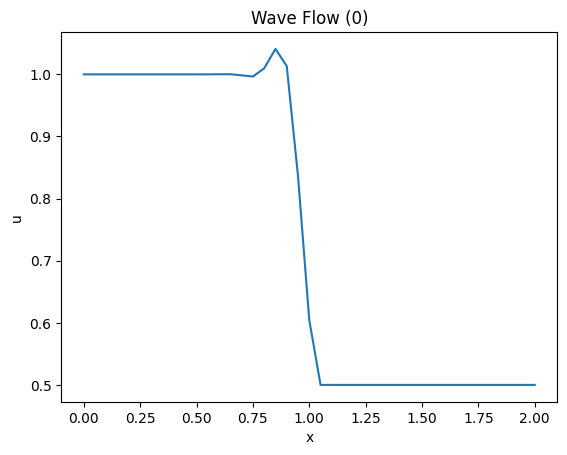

In [16]:
show_curve(x,u,"Wave Flow (%d)" % t,"x","u")    

The solution is the same, no matter which way we apply the differences. Obviously, this works better, but we see an issue near the point where the **u** value changes abruptly. 

### Memory Requirements

In the solutions above, we created storage for **u**, **up** and **du**. Can we improve this memory usage?

In examining the code, we are looping over the **x** location values from left to right (increasing **x**). In the first version of the code, we used a backward difference, meaning that for each *predictor* calculation, we needed **u** values for the current **x** location, and one point behind that one. We saved the new predicted value in a **up** array, but that value is only needed until we can consume it during the *corrector** sweep. The **corrector** needs the current predicted value plus the predicted value for the next **x** location, which we have not calculated yet.

If we store predicted values in a working array, we can perform a *corrector* calculation on for the previous **x** location as soon as we complete the *predictor* for the current location.

We can reduce the size of the **up** storage to just two *predictor* values to perform this calculation. Basically, this array will slide over the predicted values as we work through the loop. At any point in the loop, we can generate the *predictor value for this point, and the *corrector* value for the previous point. We need to consider the boundary conditions in the loop" the *predictor* must start at point one, and the *corrector* must stop one point before the maximum **x** value. At the end of the loop, we shift the stored *predictor value for the current point in preparation for the next loop.  The code should clear up this logic:

In [17]:
wdu = 0.0 # only store one value here
w = [0.0, 0.0] # the working predictor store
ureset()

# loop over time
for n in range(0,nt):
    t - n * dt
    
    # predictor - backward differences
    w[0] = u[0] # update left bundary
    for i in range(1,nx-1):
        wdu = u[i] - u[i-1]
        w[1] = u[i] - c * dt/dx * wdu
        
        # Corrector - forward differences, lags one
        wdu = w[1] - w[0]
        u[i-1] = 0.5*(u[i-1] + w[0] - c * dt/dx * wdu)
        
        # shift working storage
        w[0] = w[1]

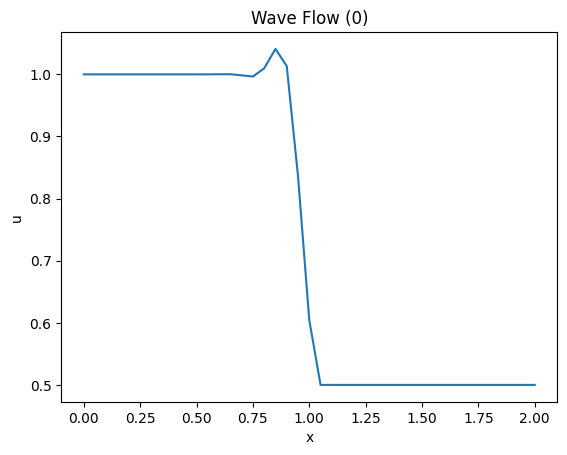

In [18]:
show_curve(x,u,"Wave Flow (%d)" % t,"x","u")    

We have reduce the code to one loop, and reduced the *predictor* storage  array from **nx** points to two. This was an important improvement back when the original code was developed, since even mainframes had limited storage available. (Not to mention desktop calculators of the day, where the code was also run!)